In [2]:
%load_ext autoreload
%autoreload 2

In [121]:
import matplotlib.pyplot as plt
import numpy as np
import sys
import pickle
from typing import List
import networkx as nx
from qtensor.tools import maxcut
import sarge
from pathlib import Path

## Set up MQLib

Install from here: https://github.com/MQLib/MQLib

In [22]:
MQLib_dir = Path().home() / 'git-built/MQLib'
MQLib_bin = MQLib_dir / 'bin/MQLib'
MQLib_heuristics = 'BURER2002' # the best so far
print('MQLib is expected to be in', MQLib_dir)
print('--Expected to see "ERROR: Invalid usage."--\n--')
print(sarge.get_stdout(str(MQLib_bin)+' --help'))

MQLib is expected to be in /home/plate/git-built/MQLib
--Expected to see "ERROR: Invalid usage."--
--
ERROR: Invalid usage.
MQLib: Library of Max-Cut and QUBO heuristics

USAGE: 
# Run Max-Cut or QUBO heuristic
./bin/MQlib -h heur_code | -hh -fM maxcut_file [-nv] [-ps] [-q | -r runtime_limit] [-s SEED]
./bin/MQlib -h heur_code | -hh -fQ qubo_file [-nv] [-ps] [-q | -r runtime_limit] [-s SEED]

# Compute metrics for an input file
./bin/MQlib -fM maxcut_file [-mh] [-m]
./bin/MQlib -fQ qubo_file [-mh] [-m]

# List the available heuristics.
./bin/MQlib -l

OPTIONS:

-fM, --fileMaxCut ARG   Filename for Max-Cut problem instance.

-fQ, --fileQUBO ARG     Filename for QUBO problem instance.

-h, --heuristic ARG     Heuristic code.

-hh, --hyperheuristic   Use the Max-Cut hyper-heuristic

-l, --listHeuristics    List all heuristic codes and brief descriptions

-m, --metrics           Output problem instance statistics.

-mh, --metricsHeader    Output header for problem instance statistics

-nv,

In [23]:
!mkdir ../mqlib_graphs

In [37]:
def run_mqlib_maxcut(file, heuristics, time=None, seed=10):
    cmd = str(MQLib_bin) + f' -h {heuristics}'
    cmd += f' -fM {file}'
    if time:
        cmd += f' -r {time}'
    cmd += f' -s {seed}'
    return sarge.get_stdout(cmd)

In [59]:
def convert_graph_to_maxcut(G: nx.Graph, file) -> List[str]:
    """ Assert maxcut with unity coefficients
    Returns:
        lines for the maxcut problem file
    """
    V = G.number_of_nodes()
    E = G.number_of_edges()
    first_line = f'{V} {E}'
    lines = [first_line]
    G = nx.convert_node_labels_to_integers(G, first_label=1)
    for i, j in G.edges:
        lines.append(f"{i} {j} 1")
    with open(test_file, 'w+') as f:
        f.writelines('\n'.join(lines))
    return lines


In [60]:
test_file = '../mqlib_graphs/test.txt'
G = nx.random_regular_graph(3, 14, seed=10) 
lines = convert_graph_to_maxcut(G, test_file)

run_mqlib_maxcut(test_file, MQLib_heuristics, time=.3)

'0.3,BURER2002,"../mqlib_graphs/test.txt",18,0.300023,[0:2e-06;18:5.5e-05]\n'

In [61]:
cost, sol = maxcut.maxcut_optimal(G)
print('Optimal maxcut', cost)

Optimal maxcut 18.0


In [85]:
def solve_mqlib_maxcut(G, time=5, seed=10):
    graph_name = '/tmp/mqlib_tmp_gr.txt'
    convert_graph_to_maxcut(G, graph_name)
    out = run_mqlib_maxcut(test_file, MQLib_heuristics, time=time, seed=seed)
    keys = ['runtime_limit', 'heuristic', 'filename', 'cost', 'runtime', 'history']
    values = out.split(',')
    res = dict(zip(keys, values))
    history = res['history'].strip()[1:-1]
    history = history.split(';')
    history = [x.split(':') for x in history]
    costs, times = zip(*history)
    history = dict(costs=[float(x) for x in costs],
                   times=[float(x) for x in times]
                  )
    res['history'] = history
    res['cost'] = float(res['cost'])
    res['runtime'] = float(res['runtime'])
    res['runtime_limit'] = float(res['runtime_limit'])
    return res

In [86]:
solve_mqlib_maxcut(G, time=.5)

{'runtime_limit': 0.5,
 'heuristic': 'BURER2002',
 'filename': '"../mqlib_graphs/test.txt"',
 'cost': 218.0,
 'runtime': 0.500259,
 'history': {'costs': [0.0, 210.0, 214.0, 216.0, 217.0, 218.0],
  'times': [2e-06, 0.000637, 0.00142, 0.002963, 0.005694, 0.006038]}}

## Do some benchmarks

### Multiple graphs

In [99]:
Ns = np.array([10, 20, 40, 80, 160, 320, 640, 1280])
time = 3
graphs = [nx.random_regular_graph(3, N) for N in Ns]
results = []
for G in graphs:
    results.append(solve_mqlib_maxcut(G, time=time))

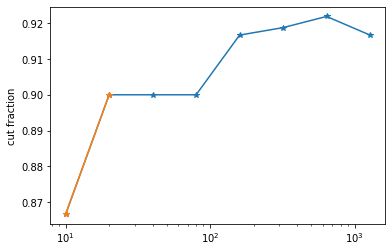

In [100]:
costs = np.array([x['cost'] for x in results])
perf_thr = 40
perfect_sol = np.array([maxcut.maxcut_optimal(G)[0] for G in graphs if G.number_of_nodes()<perf_thr])
perfect_Ns = np.array([x for x in Ns if x <perf_thr])


plt.plot(Ns, costs/Ns/3*2, '*-')
plt.plot(perfect_Ns, perfect_sol/perfect_Ns/3*2, '*-')
plt.ylabel('cut fraction')
plt.xscale('log')

### History for single graph

#### Same graph seed: look at variability of MQLib

In [118]:
select_N = 256
time = 1
seeds = range(10)
results = []
for seed in seeds:
    G = nx.random_regular_graph(3, select_N, seed=10)
    res = solve_mqlib_maxcut(G, time=time, seed=seed)
    results.append(res)

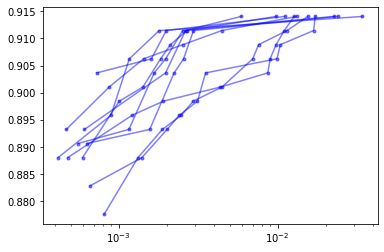

In [119]:
start = 1
for res in results:
    h = res['history']
    costs = np.array(h['costs'])[start:]
    plt.plot(h['times'][start:], costs/select_N/3*2, '.-', color='blue', alpha=.5)
    plt.xscale('log')

#### Different graph seeds

In [120]:
select_N = 256
time = 2
seeds = range(30)
results = []
for seed in seeds:
    G = nx.random_regular_graph(3, select_N, seed=seed)
    res = solve_mqlib_maxcut(G, time=time)
    results.append(res)

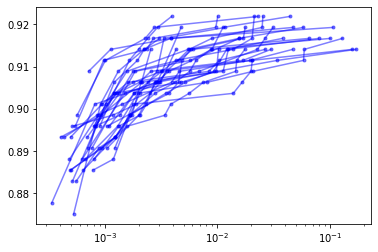

In [124]:
start = 1
for res in results:
    h = res['history']
    costs = np.array(h['costs'])[start:]
    plt.plot(h['times'][start:], costs/select_N/3*2, '.-', color='blue', alpha=.5)
    plt.xscale('log')

In [123]:
with open('../mqlib_data.pkl', 'wb+') as f:
    pickle.dump(results, f)

---